# Simulating future prices using Monte Carlo Methods

In [1]:
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

## Example: PYPL

In [2]:
def API_data(ticker):
    """import data via API"""
    
    # use your own API key
    file = open("QUANT_API_KEY.txt")
    apiKey=file.readline()
    file.close
    URL = "https://financialmodelingprep.com/api/v3/historical-price-full/"

    fullURL = URL + ticker + "?apikey=" + apiKey
    data = requests.get(fullURL).json()
    data = pd.DataFrame(data['historical'])
    data = data.iloc[::-1].reset_index()
    data.drop("index", axis = 1)
    return data

In [5]:
pypl = API_data("PYPL")
pypl.tail()

,index,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
1254,4,2022-05-09,79.89,82.1400,78.8500,79.53,79.53,25400656.0,25400656.0,-0.36,-0.451,80.17333,"May 09, 22",-0.00451
1255,3,2022-05-10,81.71,82.2700,76.1300,78.75,78.75,21126512.0,21126512.0,-2.96,-3.623,79.05000,"May 10, 22",-0.03623
1256,2,2022-05-11,77.75,80.3586,75.0200,75.17,75.17,16723171.0,16723171.0,-2.58,-3.318,76.84953,"May 11, 22",-0.03318
1257,1,2022-05-12,73.75,76.5550,71.8312,74.29,74.29,29362250.0,29362250.0,0.54,0.732,74.22540,"May 12, 22",0.00732
1258,0,2022-05-13,76.37,79.1900,76.3700,78.83,78.83,17113028.0,17113028.0,2.46,3.221,78.13000,"May 13, 22",0.03221


In [6]:
pypl['return'] = (pypl['close'] - pypl['open']) / pypl['open']

mu = (pypl.iloc[-1]['close'] - pypl.iloc[0]['close']) / pypl.iloc[0]['close']
std = pypl['return'].std()
print(mu, std)

0.5659515295987285 0.019534027478610157


## Sample Simulation

Initial price: 78.83


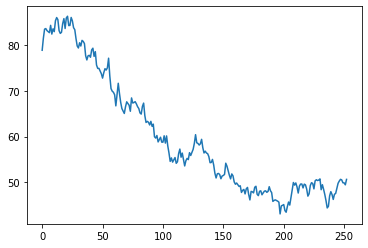

In [7]:
T = 252 # for 252 trading days
S0 = pypl.iloc[-1]['close'] # current closing price
muS = mu/len(pypl) #muS = mu*dT = mu* (1/total_time)
sigma = std

S_pos = [S0]
print("Initial price:", S0)

Z = np.random.normal(0,1, size = T)

for t in range(0, T):
    S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
    
plt.plot(S_pos)

In [8]:
pypl['date'] = pd.to_datetime(pypl['date'])

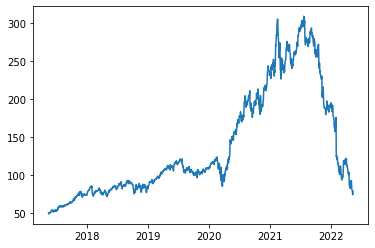

In [9]:
# time series of PYPL
plt.figure()
plt.plot(pypl['date'], pypl['close'])

## MC Simulation - 1000 trials

$$\Delta S_t =  \mu S_t\Delta t + \sigma S_t * Z_t = S_t (\mu \Delta t + \sigma Z_t)$$

$$S_{t+1} = S_{t} + S_t (\mu \Delta t + \sigma Z_t)$$

Future stock price is current stock price plus some drift $\mu$ with some volatility $Z_t$.

88.19229431975074


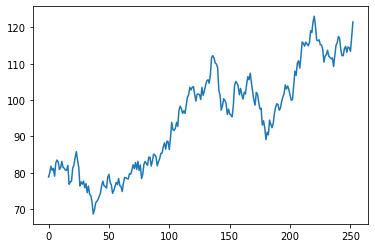

In [10]:
mu = (pypl.iloc[-1]['close'] - pypl.iloc[0]['close']) /  pypl.iloc[0]['close']
std = pypl['return'].std()

T = 252 # 1 trading year
S0 = pypl.iloc[-1]['close'] # current closing price
muS = mu/len(pypl) #muS = mu*dT = mu* (1/total_time)
sigma = std
final_points = []
returns = []

for sim in range(5000):
    S_pos = [S0]
    Z = np.random.normal(0,1, size = T)
    
    for t in range(0, T):
        S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
    final_points.append(S_pos[-1])
    returns.append((S_pos[-1]-S0)/S0) # Final endpoint vs initial for every simulation
    
print(np.average(final_points))
plt.plot(S_pos) # sample simulation

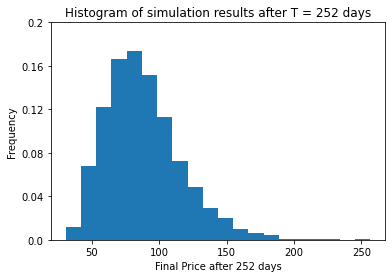

In [11]:
plt.figure()
plt.hist(final_points, bins=20) # Density = True does not work
plt.xlabel("Final Price after 252 days")
plt.title("Histogram of simulation results after T = 252 days")
plt.ylabel("Frequency")

locs, _ = plt.yticks() 
plt.yticks(locs, np.round(locs/len(final_points),3));

# log-normal prices, matches theory

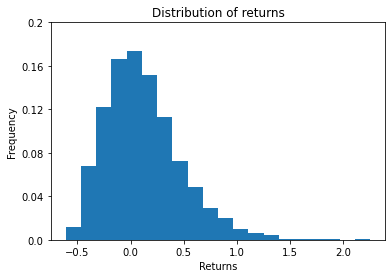

In [12]:
plt.figure()
plt.hist(returns, bins=20)
plt.xlabel("Returns")
plt.title("Distribution of returns")
plt.ylabel("Frequency")

locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/len(returns),3)); 

# linear combination of simulated results, makes sense

# Simulating for any ticker

In [13]:
### FUNCTIONS FOR PLOTTING AND SIMULATING ###

def API_data(ticker):
    """import data via API given a ticker in string format"""
    
    file = open("QUANT_API_KEY.txt")
    apiKey=file.readline()
    file.close
    URL = "https://financialmodelingprep.com/api/v3/historical-price-full/"

    fullURL = URL + ticker + "?apikey=" + apiKey
    data = requests.get(fullURL).json()
    data = pd.DataFrame(data['historical'])
    data = data.iloc[::-1].reset_index()
    data.drop("index", axis = 1)
    
    print()
    print(f"TICKER: {ticker}")
    print(f"Current price: ${data.iloc[-1]['close']}")
    print(f"Initial price: ${data.iloc[0]['close']}")
    print("---------------------------------------------")
    
    return data

def calc_mu_std(ticker_data):
    """Calculates mu and std of ticker"""
    
    total_time = len(ticker_data)
    ticker_data['return'] = (ticker_data['close'] - ticker_data['open']) / ticker_data['open']
    
    mu = (ticker_data.iloc[-1]['close'] - ticker_data.iloc[0]['close']) / ticker_data.iloc[0]['close'] # return from beginning
    std = ticker_data['return'].std()
    
    print(f"From {ticker_data.iloc[0]['date']} to {ticker_data.iloc[-1]['date']}:")
    print(f"    Average return in {total_time} days is {round(100*mu, 3)}%. \n    Standard deviation of returns during this time period is {round(std, 3)}.")
    
    return mu, std

def plot_ts(ticker_data, ticker):
    """plots time series of stock and histogram of returns"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    # change 'date' values to datetime format
    ticker_data['date'] = pd.to_datetime(ticker_data['date'])
    
    # plot time series
    axes[0].plot(ticker_data['date'], ticker_data['close'])
    axes[0].set_xlabel("Years")
    axes[0].set_ylabel("Price in USD")
    axes[0].set_title(f"Current time series of {ticker}")
    
    # plot histogram of returns
    axes[1].hist(ticker_data['return'], bins=20)
    axes[1].set_xlabel("Returns")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Histogram of current returns")
    # Density = True
    locs = axes[1].get_yticks() 
    axes[1].set_yticks(locs);
    axes[1].set_yticklabels(np.round(locs/len(ticker_data['return']),3));
    
    return

def MC_Simulation(mu0, std0, ticker_data, time, N):
    """Given ticker, ticker data, how far you want to simulate (252 is one trading year), 
    yield results of N simulations"""
    
    mu, std = mu0, std0
    T = time
    S0 = ticker_data.iloc[-1]['close']
    muS = mu/len(ticker_data)
    sigma = std
    final_points = []
    returns = []
    
    print()
    print("---------------------------------------------")
    print(f"Simulating {time} days into the future {N} times...")
    
    # MC simulate N times
    for sim in range(N):
        S_pos = [S0]
        Z = np.random.normal(0,1, size = T)

        for t in range(0, T):
            S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
        final_points.append(S_pos[-1])
    
    # Descriptive statistics for ending points
    average = np.round(np.mean(final_points), 2)
    median = np.round(np.percentile(final_points, 50), 2)
    twentyfive = np.round(np.percentile(final_points, 25), 2)
    seventyfive = np.round(np.percentile(final_points, 75), 2)
    
    print()
    print(f"Average ending price: ${average}  ({round(100*(average-S0)/S0, 2)}%)")
    print(f"Median ending price: ${median}  ({round(100*(median-S0)/S0, 2)}%)")
    print(f"25th percentile of ending price: ${twentyfive}  ({round(100*(twentyfive-S0)/S0, 2)}%)")
    print(f"75th percentile of ending price: ${seventyfive}  ({round(100*(seventyfive-S0)/S0, 2)}%)")
    
    return final_points

def plot_hist(end_points, time, ticker):
    """Plot histogram and whisker plot of results given array of end points of simulations"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f"Simulation Results: {ticker} ({time} days)", fontsize=18, y = 1)
    
    # plot histogram
    axes[0].hist(end_points, bins=20)
    axes[0].set_xlabel("Ending Price")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Histogram of future prices")
    # show density of histogram
    locs = axes[0].get_yticks() 
    axes[0].set_yticks(locs);
    axes[0].set_yticklabels(np.round(locs/len(end_points),3));
  
    # plot boxplot
    sns.boxplot(data=end_points, orient="h", ax=axes[1])
    plt.title("Boxplot of future prices")
    plt.xlabel("Price in USD")
    
    return

### Wrapper functions

In [14]:
def simulate(ticker, time, N):
    """Wrapper function: Given ticker name, # of future days, and how many simulations,
    simulate and graph results"""
    
    data = API_data(ticker)
    mu, std = calc_mu_std(data)
    plot_ts(data, ticker)
    results = MC_Simulation(mu, std, data, time, N)
    plot_hist(results, time, ticker)
    
    return

In [15]:
def compare_times(ticker, time1, time2, N):
    """Wrapper function: comparing two different future time frames of same stock"""
    
    data = API_data(ticker)
    mu, std = calc_mu_std(data)
    plot_ts(data, ticker)
    # first time
    results = MC_Simulation(mu, std, data, time1, N)
    plot_hist(results, time1, ticker)
    
    #second time
    results = MC_Simulation(mu, std, data, time2, N)
    plot_hist(results, time2, ticker)
    
    return

In [16]:
def compare_stocks(ticker1, ticker2, time, N):
    """Wrapper function: comparing simulated prices of two different stocks"""
    
    #first stock
    data = API_data(ticker1)
    mu, std = calc_mu_std(data)
    results = MC_Simulation(mu, std, data, time, N)
    plot_hist(results, time, ticker1)
    
    print()
    print("-----------------------------------------------------------------------------")
    
    #second stock
    data2 = API_data(ticker2)
    mu, std = calc_mu_std(data2)
    results = MC_Simulation(mu, std, data2, time, N)
    plot_hist(results, time, ticker2)
    
    return

# Simulations


TICKER: SPY
Current price: $401.72
Initial price: $240.080002
---------------------------------------------
From 2017-05-16 to 2022-05-13:
    Average return in 1259 days is 67.328%. 
    Standard deviation of returns during this time period is 0.009.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $458.99  (14.26%)
Median ending price: $454.51  (13.14%)
25th percentile of ending price: $413.05  (2.82%)
75th percentile of ending price: $499.7  (24.39%)


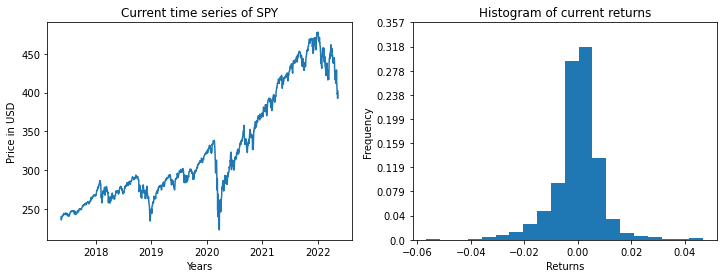

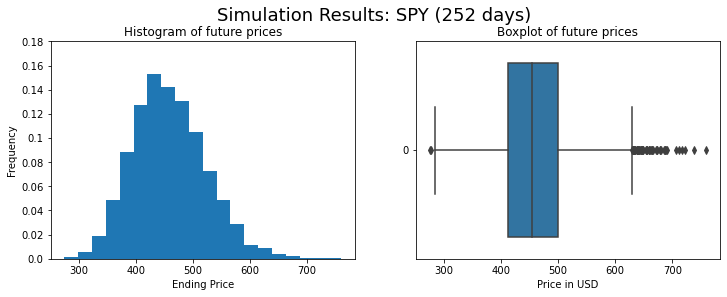

In [20]:
# args: ticker, time, #simulations
simulate("SPY", 252, 5000)


TICKER: O
Current price: $67.41
Initial price: $51.560078
---------------------------------------------
From 2017-05-16 to 2022-05-13:
    Average return in 1259 days is 30.741%. 
    Standard deviation of returns during this time period is 0.015.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $71.73  (6.41%)
Median ending price: $69.89  (3.68%)
25th percentile of ending price: $59.43  (-11.84%)
75th percentile of ending price: $81.51  (20.92%)

---------------------------------------------
Simulating 500 days into the future 5000 times...

Average ending price: $75.93  (12.64%)
Median ending price: $71.93  (6.71%)
25th percentile of ending price: $57.26  (-15.06%)
75th percentile of ending price: $90.19  (33.79%)


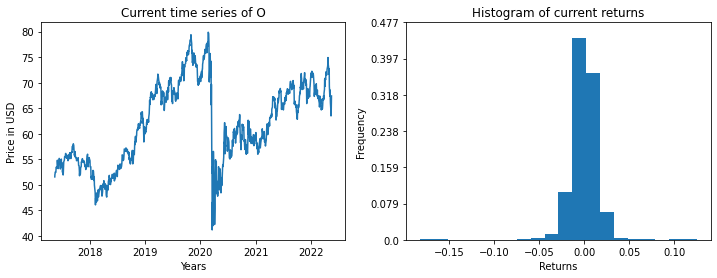

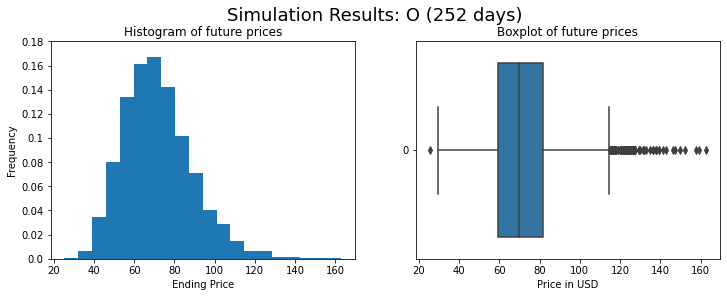

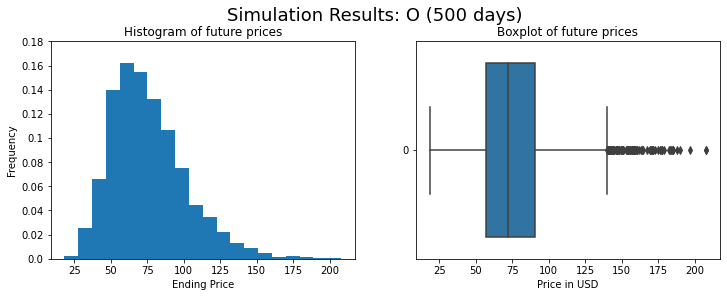

In [18]:
# args: ticker, time 1, time 2, #simulations
compare_times("O", 252, 500, 5000)


TICKER: PEP
Current price: $173.72
Initial price: $113.790001
---------------------------------------------
From 2017-05-16 to 2022-05-13:
    Average return in 1259 days is 52.667%. 
    Standard deviation of returns during this time period is 0.011.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $193.35  (11.3%)
Median ending price: $190.09  (9.42%)
25th percentile of ending price: $168.44  (-3.04%)
75th percentile of ending price: $214.99  (23.76%)

-----------------------------------------------------------------------------

TICKER: KO
Current price: $65.72
Initial price: $43.849998
---------------------------------------------
From 2017-05-16 to 2022-05-13:
    Average return in 1259 days is 49.875%. 
    Standard deviation of returns during this time period is 0.01.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $72.69  (10.61%)
Media

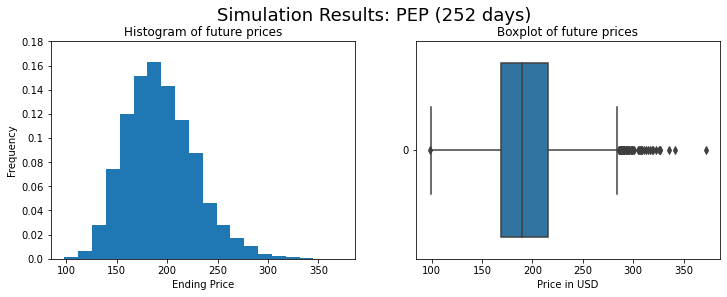

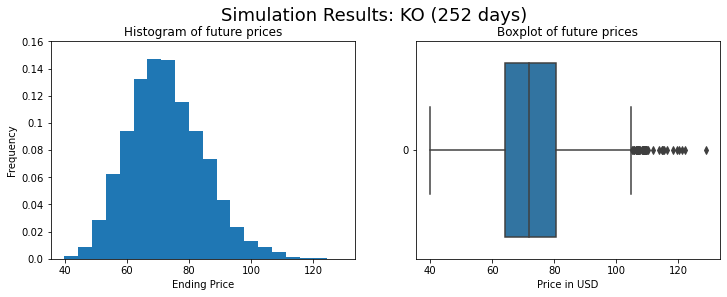

In [19]:
# args: ticker 1, ticker 2, time, #simulations
compare_stocks("PEP", "KO", 252, 5000)